##  01 - Carregando as Bibliotecas

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize.toktok import ToktokTokenizer
import nltk
import re
import unicodedata

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix

In [ ]:
tokenizer = ToktokTokenizer()
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('portuguese')

In [ ]:
pip install Unidecode

In [ ]:
# import required module
import unidecode
 
# assign string
stringList = stopword_list
 
print('\nLista Original de StopWords:\n', stopword_list)
 
for i in range(len(stopword_list)):
    stopword_list[i] = unidecode.unidecode(stopword_list[i])

print('\nNova Lista de StopWords:\n', stopword_list)

##  02 - Carregando o DataFrame

In [ ]:
df = pd.read_csv("dataset.csv", sep="|")
df.head(3)

,musica,artista,compositor,letra
0,Eu Não Sou Manivela,Ary Barroso,Ary Barroso - 1953,Você não tem nem a metade Do valor que tinha ...
1,Mulata Beleza,Arlindo Cruz,Zé Roberto,Eu também fico o dia todo na janela Esperando...
2,Vai Pro Lado de Lá,Candeia,"Candeia, Euclenes",Vai pro lado de lá Vai pro lado de lá Vai pro...


##  03 - Análise Exploratória

In [ ]:
# cada letra de samba é um documento
data = [lyrics for lyrics in df.letra] 
print("Temos %d documentos." %len(data))

Temos 3118 documentos.


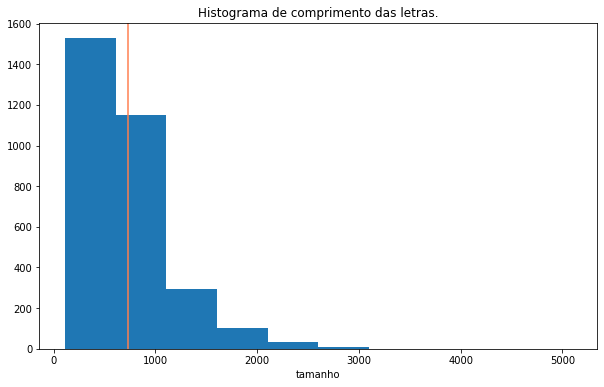

In [ ]:
avg_len = sum(df["letra"].str.len() ) / float(len(df["letra"].str.len()))

plt.figure(figsize=(10,6))
plt.hist(df["letra"].str.len() )
plt.axvline(avg_len, color='coral')
plt.title('Histograma de comprimento das letras.')
plt.xlabel('tamanho')
plt.show()

##  04 - Limpando as Letras

In [ ]:
'''Remove stopwords'''
def remove_stopwords(text):
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
  filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
  filtered_text = ' '.join(filtered_tokens)
  return filtered_text

'''Remove acentos'''
def remove_accent(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

'''Remove caracteres especiais'''
def remove_special_characters(text, remove_digits=False):
  special_char_pattern = re.compile(r'([{.(-)!}])')
  text = special_char_pattern.sub(" \\1 ", text)
  pattern = r'[^a-zA-z\s]'
  text = re.sub(pattern, '', text)
  return text

In [ ]:
#Funções para limpar texto: chama todas as funções declaradas acima e faz mais alguns pré processamentos
def clean(corpus):

  normalized_corpus = []
  for doc in corpus:
    # remove acentuação
    doc = remove_accent(doc)

    # coloca tudo em caixa baixa
    doc = doc.lower()

    # remove caracteres especiais 
    doc = remove_special_characters(doc)

    # remove stopwords
    doc = remove_stopwords(doc)

    # insere na lista o texto após limpeza
    normalized_corpus.append(doc)

  return normalized_corpus # retorna corpus pré processado

In [ ]:
normalized_corpus = clean(df.letra.to_list())

##  05 - WordCloud

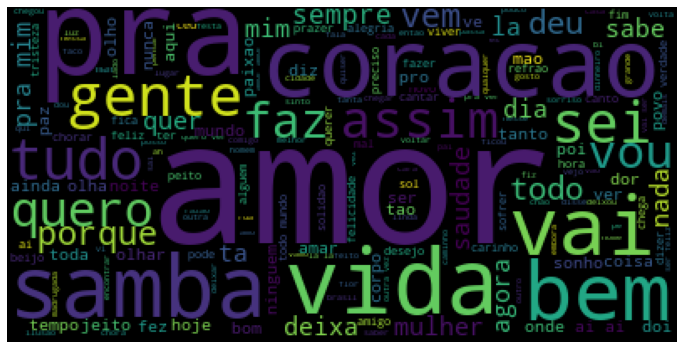

In [ ]:
wordcloud = WordCloud().generate(str(normalized_corpus))

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

##  06 - Detectando Outliers

In [ ]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                            )

# data_vectorized = vectorizer.fit_transform(data_lemmatized)
data_vectorized = vectorizer.fit_transform(normalized_corpus)

In [ ]:
db = DBSCAN(eps=30, min_samples=10).fit(data_vectorized)
labels = db.labels_

In [ ]:
number_outliers = (np.sum(labels == -1))

In [ ]:
x = csr_matrix(data_vectorized, dtype=np.int8).toarray()

In [ ]:
pca = PCA(n_components=2)
pca.fit(x)
data_pca2 = pd.DataFrame(pca.transform(x))

In [ ]:
data_pca2['labels'] = labels

In [ ]:
Y = data_pca2.to_numpy()

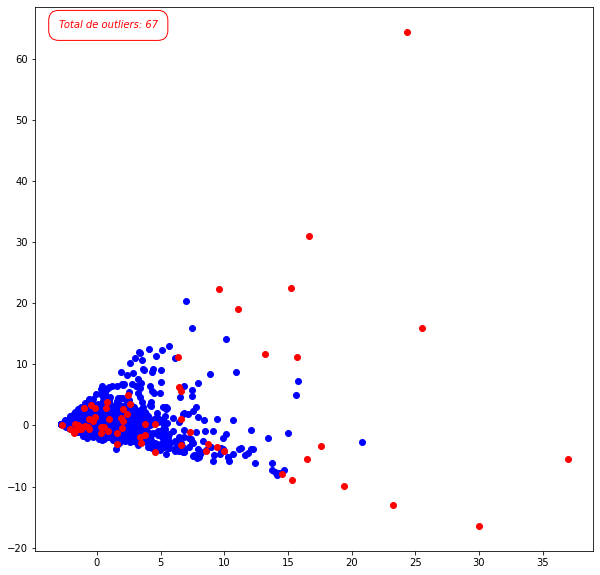

In [ ]:
plt.figure(figsize=(10,10))

unique_labels = set(labels)
colors = ['blue', 'red']

for color,label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(Y[:,0][sample_mask], Y[:, 1][sample_mask], 'o', color=color);

plt.text(-3, 65, "Total de outliers: " + str(number_outliers), style='italic', color='red',
        bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=1'))

plt.show()

In [ ]:
df['label'] = labels

In [ ]:
x = df.groupby(["artista"]).size().sort_values(ascending=False)
y = df[df["label"]==-1].groupby(["artista"]).size().sort_values(ascending=False)

In [ ]:
df_ouliers = pd.concat([x, y], axis=1)

In [ ]:
df_ouliers = df_ouliers.rename(columns={df_ouliers.columns[0]: 'letras'})
df_ouliers = df_ouliers.rename(columns={df_ouliers.columns[1]: 'ouliers'})

In [ ]:
df_ouliers['ouliers'] = df_ouliers['ouliers'].fillna(0)
df_ouliers['ouliers'] = df_ouliers['ouliers'].apply(np.int64)

In [ ]:
df_ouliers[(df_ouliers['ouliers']>0)].style.background_gradient(cmap= 'YlOrBr')

,letras,ouliers
Alcione,376,4
Bezerra da Silva,292,39
Beth Carvalho,252,3
Benito Di Paula,231,7
Alexandre Pires,195,2
Agepê,166,4
Carmen Miranda,125,1
Adoniran Barbosa,104,1
Bom Gosto,94,1
Candeia,66,5
